<a href="https://colab.research.google.com/github/jiheddachraoui/Covid19-ultrasound-Compressed-video-based-Frame-level-Scoring/blob/main/custom_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Pneumonia using Convolutional Neural Network (CNN)


## Import The Required Libraries


In [ ]:
# basics
import sys
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

import pickle 
''''
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"'''

# Keras Libraries
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from tensorflow.keras.utils import load_img, img_to_array

from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.utils import  load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import keras.backend


Mounted at /content/gdrive


In [ ]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
#tf.set_random_seed(seed_value)
tf.random.set_seed(seed_value)
# 5. For layers that introduce randomness like dropout, make sure to set seed values 
#model.add(Dropout(0.25, seed=seed_value))

#6 Configure a new global `tensorflow` session

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
project_path = r"/content/gdrive/MyDrive/Dataset/grayscale_data/"
train_path = project_path + r"train"
test_path = project_path + r"test"
val_path = project_path + r"valid"

In [ ]:
hyper_dimension = 224
hyper_batch_size = 128
hyper_epochs = 100
hyper_feature_maps=32

## Training in grayscale instead of RGB
hyper_channels = 1
hyper_mode = 'grayscale'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(rescale=1.0/255.0) 


train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    target_size = (hyper_dimension, hyper_dimension),
                                                    batch_size = hyper_batch_size, 
                                                    color_mode = hyper_mode,
                                                    class_mode = 'categorical', 
                                                    seed = 42)
val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'categorical',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)
test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'categorical',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)

test_generator.reset()

Found 17519 images belonging to 4 classes.
Found 7298 images belonging to 4 classes.
Found 1073 images belonging to 4 classes.


## Top 3 Models


We first created a function to create two charts that shows the progress of training the neural network.


In [ ]:
def create_charts(cnn, cnn_model):
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout();
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [ ]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
checkpoint=checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/gdrive/MyDrive/Dataset/output/checkpoints/my_model2_{epoch}.h5",
   save_best_only=True,
    verbose=1
)

callbacks=[early,checkpoint]

### Model #1: Conv2D x 3 + 64 dense units


In [ ]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))
                                
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='softmax', units=4))



cnn.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=[AUC()])
cnn_model1 = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = hyper_epochs, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              callbacks=callbacks,
                              verbose=1)
cnn1=cnn


Epoch 1/100
137/137 [==============================] - ETA: 0s - loss: 1.1340 - auc_4: 0.7612 
Epoch 1: val_loss improved from inf to 1.57977, saving model to /content/gdrive/MyDrive/Dataset/output/checkpoints/my_model_1.h5
137/137 [==============================] - 2935s 21s/step - loss: 1.1340 - auc_4: 0.7612 - val_loss: 1.5798 - val_auc_4: 0.5831
Epoch 2/100
 74/137 [===============>..............] - ETA: 8:56 - loss: 0.7403 - auc_4: 0.9079

In [ ]:
#create_charts(cnn, cnn_model1)

### Model #2: Conv2D x 4 + 64 dense units


In [ ]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dropout(0.4))
cnn.add(Dense(activation='softmax', units=4))

cnn.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=[AUC()])
cnn_model2 = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = hyper_epochs, 
                              validation_data = val_generator,
                              callbacks=callbacks,
                              validation_steps = len(val_generator))
cnn2=cnn

In [ ]:
#create_charts(cnn, cnn_model)

### Model #3: Conv2D x 2 + 64 dense units


In [ ]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='softmax', units=4))

cnn.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=[AUC()])
cnn_model3 = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = hyper_epochs, 
                              validation_data = val_generator,
                              callbacks=callbacks,
                              validation_steps = len(val_generator), 
                              verbose=1)
cnn3=cnn

In [ ]:
#create_charts(cnn, cnn_model)

### Model #4 (I): Conv2D x 3 + 128 dense units (100 epochs)


In [ ]:
# Conv2D x 3 + 128 dense units
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='softmax', units=4))

cnn.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=[AUC()])
cnn_model4 = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = hyper_epochs, 
                              validation_data = val_generator,
                              callbacks=callbacks,
                              validation_steps = len(val_generator), 
                              verbose=1)
cnn4=cnn

In [ ]:
#create_charts(cnn, cnn_model)

### Model #4 (II): Conv2D x 3 + 128 dense units (200 epochs)


In [ ]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='softmax', units=4))

cnn.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=[AUC()])
cnn_model41 = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = hyper_epochs, 
                              callbacks=callbacks,
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=1)
cnn41=cnn

Epoch 1/100
137/137 [==============================] - ETA: 0s - loss: 1.0962 - auc: 0.7800 
Epoch 1: val_loss improved from inf to 1.61877, saving model to /content/gdrive/MyDrive/Dataset/output/checkpoints/my_model2_1.h5
137/137 [==============================] - 3993s 28s/step - loss: 1.0962 - auc: 0.7800 - val_loss: 1.6188 - val_auc: 0.5901
Epoch 2/100
137/137 [==============================] - ETA: 0s - loss: 0.6094 - auc: 0.9376
Epoch 2: val_loss did not improve from 1.61877
137/137 [==============================] - 712s 5s/step - loss: 0.6094 - auc: 0.9376 - val_loss: 2.3371 - val_auc: 0.5682
Epoch 3/100
137/137 [==============================] - ETA: 0s - loss: 0.4416 - auc: 0.9661
Epoch 3: val_loss did not improve from 1.61877
137/137 [==============================] - 701s 5s/step - loss: 0.4416 - auc: 0.9661 - val_loss: 2.7948 - val_auc: 0.5363
Epoch 4/100
137/137 [==============================] - ETA: 0s - loss: 0.3702 - auc: 0.9759
Epoch 4: val_loss did not improve from 

9/9 [==============================] - 264s 33s/step


ValueError: ignored

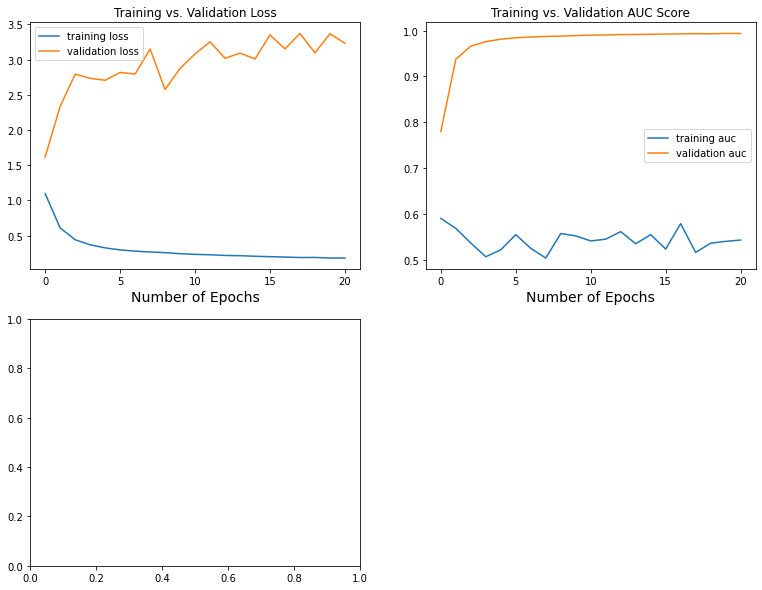

In [ ]:
create_charts(cnn41, cnn_model41)

### Model #5


In [ ]:
## batch size: 64 Conv2D (filter: 32, 64, 128)  x 3 + different dense units + Batch Normalization
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=64, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=128, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(BatchNormalization())
cnn.add(Dense(activation='relu', units=1024))
cnn.add(Dense(activation='relu', units=512))
cnn.add(Dense(activation='softmax', units=4))

cnn.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=[AUC()])
cnn_model5 = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = hyper_epochs, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              callbacks=callbacks, 
                              verbose=1)

In [ ]:
#create_charts(cnn, cnn_model)

### Model #6


In [ ]:
## Conv2D (filter: 32, 64, 128)  x 3 + different dense units + Batch Normalization + Dropout Dense layer
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=64, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.3))

cnn.add(Conv2D(filters=128, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.3))

cnn.add(Flatten())

cnn.add(BatchNormalization())
cnn.add(Dense(activation='relu', units=512))
cnn.add(Dropout(0.25))
cnn.add(Dense(activation='relu', units=256))
cnn.add(Dropout(0.25))
cnn.add(Dense(activation='softmax', units=4))

cnn.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=[AUC()])
cnn_model6 = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = hyper_epochs, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              callbacks=callbacks,
                              verbose=1)
cnn6=cnn

Epoch 1/100
137/137 [==============================] - ETA: 0s - loss: 1.1837 - auc: 0.7723 
Epoch 1: val_loss improved from inf to 1.39885, saving model to /content/gdrive/MyDrive/Dataset/output/checkpoints/my_model2_1.h5
137/137 [==============================] - 5344s 38s/step - loss: 1.1837 - auc: 0.7723 - val_loss: 1.3988 - val_auc: 0.4816
Epoch 2/100
137/137 [==============================] - ETA: 0s - loss: 0.6633 - auc: 0.9260 
Epoch 2: val_loss did not improve from 1.39885
137/137 [==============================] - 2767s 20s/step - loss: 0.6633 - auc: 0.9260 - val_loss: 1.4060 - val_auc: 0.4611
Epoch 3/100
 65/137 [=============>................] - ETA: 21:55 - loss: 0.4960 - auc: 0.9580

KeyboardInterrupt: ignored

In [ ]:
#create_charts(cnn, cnn_model)